In [ ]:
!pip install -q kagglehub

import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files
from PIL import Image

In [ ]:


# download dataset
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)
vowel_classes = ['A', 'E', 'I', 'O', 'U', 'C', "D", "W", "L"]


base_dir = os.path.join(path, "asl_alphabet_train/asl_alphabet_train")

# image loader
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest'

)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    classes=vowel_classes
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=vowel_classes
)

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras import regularizers

layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001))


Path to dataset files: /kaggle/input/asl-alphabet
Found 21600 images belonging to 9 classes.
Found 5400 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Conv2D name=conv2d_3, built=False>

In [ ]:
# train
history = model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 162s 449ms/step - accuracy: 0.1421 - loss: 2.1627 - val_accuracy: 0.3013 - val_loss: 1.8680
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.3701 - loss: 1.6686 - val_accuracy: 0.4350 - val_loss: 1.5073
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.5122 - loss: 1.2975 - val_accuracy: 0.5639 - val_loss: 1.2004
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.6180 - loss: 1.0346 - val_accuracy: 0.5952 - val_loss: 1.0201
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.6706 - loss: 0.9059 - val_accuracy: 0.6256 - val_loss: 0.9428
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.7184 - loss: 0.7762 - val_accuracy: 0.6528 - val_loss: 0.9020
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - accuracy: 0.7430 - loss: 0.7109 - val_accuracy: 0.6861 - val_loss: 0.7772
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.7596 - loss: 

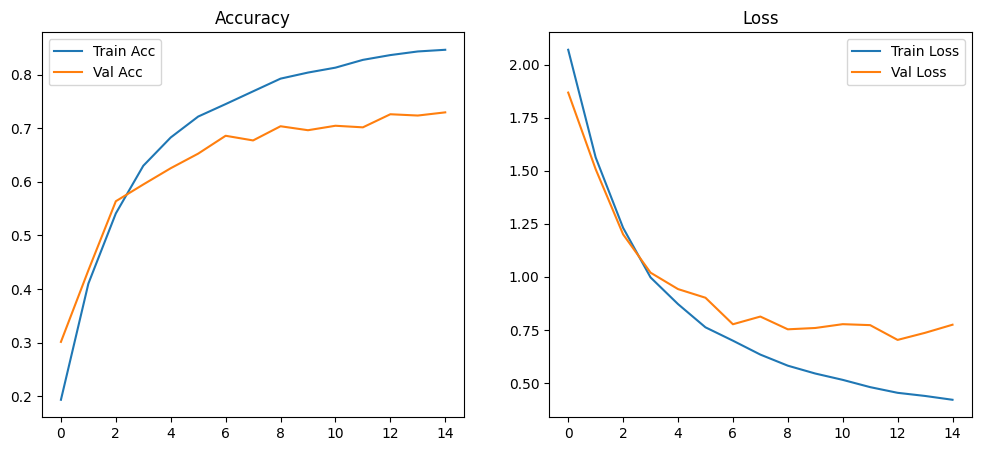

In [ ]:
# accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


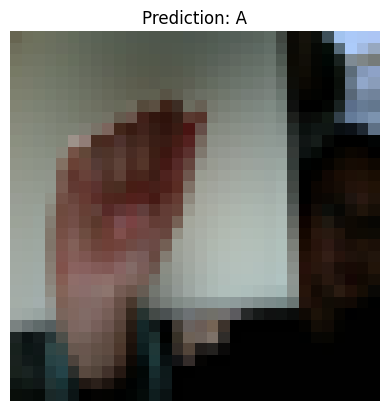

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt

def predict_from_webcam(model, class_indices, target_size=(32, 32)):
    # JavaScript to open webcam and capture image
    js = """
    async function captureImage() {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for the capture button
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg');
    }
    captureImage();
    """
    display(Javascript(js))
    data_url = eval_js("captureImage()")
    header, encoded = data_url.split(',', 1)
    image_data = b64decode(encoded)
    img = Image.open(io.BytesIO(image_data))

    # Resize and preprocess
    img_resized = img.resize(target_size)
    img_array = np.array(img_resized) / 255.0

    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]  # remove alpha

    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)[0]
    class_index = np.argmax(pred)
    class_label = list(class_indices.keys())[class_index]

    # Show result
    plt.imshow(img_resized)
    plt.title(f"Prediction: {class_label}")
    plt.axis('off')
    plt.show()
predict_from_webcam(model, train_data.class_indices)


In [ ]:
# upload image and predict
print("\nUpload a test image (ASL hand sign)...")
uploaded = files.upload()

for fn in uploaded.keys():
    img = Image.open(fn).resize((32,32))
    img_array = np.array(img) / 255.0
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]  # remove alpha
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0]
    class_index = np.argmax(pred)
    class_label = list(train_data.class_indices.keys())[class_index]

    plt.imshow(img)
    plt.title(f"Prediction: {class_label}")
    plt.axis('off')
    plt.show()


Upload a test image (ASL hand sign)...


In [ ]:
model.save("/asl_model.keras")  # saves structure + weights

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/asl_model.keras')